Credit to:
- [Magho's "Fitting Gaussian Mixture Models with EM"](https://github.com/Magho/Fitting-Gaussian-Mixture-Models-with-EM) for part of the implementation
- [Jake VanderPlas's "In Depth: Gaussian Mixture Models"](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html) for part of the implementation
- [InfoMIT's "Traditional Derivation of EM"](https://www.informit.com/articles/article.aspx?p=363730&seqNum=2) for part of the theoretical derivation
- [Prof. Feng Liang's lectures](https://publish.illinois.edu/liangf/teaching/stat-542/stat-542-lectures/) and [Prof. Ruoqing Zhu's lectures](https://teazrq.github.io/stat542/lecture.html) for part of the theoretical derivation

In [ ]:
from typing import List, Union, Dict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from tqdm.notebook import tqdm
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# **1. Motivating Problem: Univariate (1-D) Gaussian Mixture Model**

*A* random variable $X$ is said to follow the univariate normal (or Gaussian) distribution, parameterized by $\mu$ (or mean) and $\sigma^2$ (or variance), denoted by $X \sim N(\mu, \sigma^2)$, if its probability density function is
$$
    f_N(x; \mu, \sigma) = \dfrac{1}{\sqrt{2\pi\sigma^2}} \exp{-\dfrac{(x-\mu)^2}{2\sigma^2}}
$$ 

A Gaussian mixture is a model parameterized by $\theta = (\vec{\mu}, \vec{\sigma}, \vec{\pi})$ and has the pdf of
$$
    f(x; \theta) = \sum_{k=1}^{K} \pi_k f_{N}(x; \mu_k, \sigma_k)
$$
where:
- $K$ is the number of components in the mixture, 
- $\vec{\mu} = (\mu_1, \mu_2, \ldots, \mu_K)$ and $\vec{\sigma} = (\sigma_1, \sigma_2, \ldots, \sigma_K)$ are the parameters of each component in the mixture,
- $\vec{\pi} = (\pi_1, \pi_2, \ldots, \pi_K)$ are the mixing weights.

In [ ]:
def generate_ugmm(sample_size: int, 
                  means: List[float], 
                  variances: List[float], 
                  weights: List[float]) -> Union[List[float], List[int]]:
    '''
        Generate data sampled from a univariate Gaussian mixture.
    '''

    # Decide which distribution each point belongs to
    classes = np.random.choice(len(weights), sample_size, p=weights)

    # Generate a point as a random sample of its corresponding distribution
    data = [np.random.normal(means[k], np.sqrt(variances[k])) for k in classes]

    return data, classes

Given a data $X = (x_1, x_2, \ldots, x_N)$ of $N$ points, assuming that the data follow a Gaussian mixture model with parameters $\theta$, we want to estimate these parameters.

The log-likelihood is
$$
    l(\theta) 
    = \log{p(X| \theta)}
    = \log{\prod_{i=1}^{N} f(x_i; \theta)}
    = \sum_{i=1}^{N} \log{f(x_i; \theta)}
    = \sum_{i=1}^{N} \log \sum_{k=1}^{K} \pi_k f_N(x_i; \mu_k, \sigma_k)
$$

This can be optimize by some optimization techniques, such as gradient descent. However, there is an easier and more elegant way by utilizing the EM algorithm.

***NOTE***: for numerical stability, to calculate

$$
    \log \sum_{k=1}^{K} \pi_k f_N(x; \mu_k, \sigma_k)
    =
    \log \sum_{k=1}^{K} 
    \dfrac{\pi_k}{\sqrt{2\pi\sigma_k^2}} 
    \exp{-\dfrac{(x_i-\mu_k)^2}{2\sigma_k^2}} 
$$

we transform it into 

$$
    \log \sum_{k=1}^{K}
    \exp{\left[
        \log \pi_k 
        - \dfrac{1}{2}\log{2\pi\sigma_k^2} - \dfrac{(x_i - \mu_k)^2}{2\sigma_k^2}
    \right]}
$$

and use

$$
    \log \sum e^{t_i}
    = \log \sum e^{t_i-T} e^T 
    = T + \log \sum e^{t_i - T}
$$

$$
    T = \max t_i
$$

In [ ]:
def log_sum_exp(T: List[float]) -> float:
    '''
        Compute $\log{\sum_i \exp{T_i}}$ for a vector T.

        We use the fact that:
        \log \sum \exp T_i 
            = T_max + \log \sum \exp (T_i - T_max)
    '''
    return np.max(T) + np.log(np.sum(np.exp(T - np.max(T))))

def loglikelihood_ugmm(data: List[float], 
                       means: List[float], 
                       variances: List[float], 
                       weights: List[float]) -> float:
    '''
        Compute the log-likelihood of the data for a Univariate Gaussian 
        Mixture Model with the given parameters.
    '''
    K = len(weights)
    ll = 0

    # Iterate over all data
    for d in data:
        # Compute the exponentiation term for each class k
        T = np.zeros(K)
        for k in range(K):
            e = (d - means[k]) ** 2 / (2 * variances[k])
            T[k] += np.log(weights[k])
            T[k] -= 1/2. * np.log(2 * np.pi * variances[k]) + e

        # Calculate the logarithm of the sum of the above exponentials
        ll += log_sum_exp(T)
    return ll

# **2. The Expectation-Maximization (EM) algorithm**

The EM algorithm is specifically designed for models with **latent variables**. Instead of dealing with the **incomplete data** $X$, it takes into consideration the hidden (latent) variables $Z = (z_1, z_2, \ldots, z_N)$, where $z_i$ indicates the *class* the $i$-th data point belongs to. Together, $(X, Z)$ makes the **complete data**.

The algorithm is an iterative method, each iteration consists of 2 steps:
- **E-step**: for the current parameter $\theta^{(t)}$, find 
$$
    q(\theta|\theta^{(t)}) = \mathbb{E}_{Z|X, \theta^{(t)}} \log{p(X, Z|\theta)}
$$
which is the expectation of the log-likelihood of the full data.
- **M-step**: find $\theta^{(t+1)}$ as the maximizer of $q(\theta|\theta^{(t)})$. In other words,
$$
    \theta^{(t+1)} = \arg\max_\theta q(\theta|\theta^{(t)})
$$

## Proof of correctness

We can show that
$$
    q(\hat{\theta}|\theta^{(t)}) \geq q(\theta|\theta^{(t)}) \Rightarrow p(X|\hat{\theta}) \geq p(X|\theta)
$$

which means that by optimizing $q(\theta|\theta^{(t)})$ we are essentially increasing (or at least not decreasing) the loglikelihood.

$$
    q(\hat{\theta}|\theta^{(t)}) - q(\theta|\theta^{(t)}) 
    = \mathbb{E}_{Z|X, \theta^{(t)}} \log{\dfrac{p(X, Z|\hat{\theta})}{p(X, Z|\theta)}}
    = \mathbb{E}_{Z|X, \theta^{(t)}} \log{\dfrac{p(Z|X,\hat{\theta}) p(X|\hat{\theta})}{p(Z|X,\theta) p(X|\theta)}}
    = \log{\dfrac{p(X|\hat{\theta})}{p(X|\theta)}} - \mathbb{E}_{Z|X, \theta^{(t)}} \log{\dfrac{p(Z|X,\theta)}{p(Z|X,\hat{\theta})}}
$$

By $q(\hat{\theta}|\theta^{(t)}) \geq q(\theta|\theta^{(t)})$, we have
$$
    \log{\dfrac{p(X|\hat{\theta})}{p(X|\theta)}} \geq \mathbb{E}_{Z|X, \theta^{(t)}} \log{\dfrac{p(Z|X,\theta)}{p(Z|X,\hat{\theta})}} \geq 0
$$
or $p(X|\hat{\theta}) \geq p(X|\theta)$

The second inequality holds because it is the KL-divergence of two distribution which is always non-negative.


# **3. Example 1: Solving the Motivating Problem (Section 1)**

## **3.1. Application of the EM algorithm to Univariate GMM**

### **E-Step**

#### Derivation

With the additional information of $\vec{Z}$, we can state the likelihood as follows.
$$
    p(X, Z|\theta)
    = \prod_{i=1}^{N} \prod_{k=1}^{K} [\pi_k f_N(x_i; \mu_k, \sigma_k)]^{\mathbb{I}(z_i=k)}
$$
where $\mathbb{I}(z_i = k) = 1$ when $z_i = k$ and $0$ otherwise.

The log-likelihood is then
$$
    \log p(X, Z|\theta) 
    = \sum_{i=1}^{N} \sum_{k=1}^{K} \mathbb{I}(z_i=k) [\log{\pi_k} + \log{f_N(x_i; \mu_k, \sigma_k)]} 
$$

Taking expectation over $Z|X, \theta^{(t)}$ we get
$$
    g(\theta|\theta^{(t)}) 
    = \sum_{i=1}^{N} \sum_{k=1}^{K} 
    \left[ 
        \mathbb{E}_{\vec{Z}|\vec{X}, \theta^{(t)}}
        \mathbb{I}(z_i=k) 
    \right]
    [\log \pi_k + \log f_N(x_i; \mu_k, \sigma_k)]
$$

Now,
$$
    \mathbb{E}_{Z|X, \theta^{(t)}} \mathbb{I}(z_i = k) 
    = P(Z_i = k|X, \theta^{(t)}) 
    = \dfrac{\pi^{(t)}_k f_N(x_i; \mu^{(t)}_k, \sigma^{(t)}_k)}{\sum_{j=1}^{K} \pi^{(t)}_j f_N(x_i; \mu^{(t)}_j, \sigma^{(t)}_j)}
$$
Let this be called the **responsibility** of class $k$ to the $i$-th data point at the $t$-th step, denoted by $\gamma_{i,k}^{(t)}$.

#### Implementation

In short, at the end of E-step, we have
$$
    g(\theta|\theta^{(t)})
    = \sum_{i=1}^{N} \sum_{k=1}^{K} \gamma_{i, k}^{(t)} [\log \pi_k + \log f_N(x_i; \mu_k, \sigma_k)]
$$
where
$$
    \gamma_{i, k}^{(t)} = \dfrac{\pi^{(t)}_k f_N(x_i; \mu^{(t)}_k, \sigma^{(t)}_k)}{\sum_{j=1}^{K} \pi^{(t)}_j f_N(x_i; \mu^{(t)}_j, \sigma^{(t)}_j)}
$$

In [ ]:
def e_step_ugmm(N, K, data, means_t, variances_t, weights_t):
    resp_t = np.zeros((N, K))

     # Compute the responsibility matrix
    for i in range(N):
        for k in range(K):
            fN = norm.pdf(data[i], loc=means_t[k], scale=np.sqrt(variances_t[k]))
            resp_t[i, k] = weights_t[k] * fN
        
    # Normalize by row sum
    row_sums = resp_t.sum(axis=1)[:, np.newaxis]
    resp_t /= row_sums

    return resp_t

### **M-step**

#### Derivation

We find $\theta^{(t+1)}$ by finding the parameters maximizing
$$
    g(\theta|\theta^{(t)})
    = \sum_{i=1}^{N} \sum_{k=1}^{K} \gamma_{i, k}^{(t)} [\log \pi_k + \log f_N(x_i; \mu_k, \sigma_k)]
$$

For the **means** and **variances**, it is possible through setting the derivative equal to $0$.

##### <ins>**Means**</ins>

For the means,
$$
    \dfrac{\partial g(\theta|\theta^{(t)})}{\partial \mu_k} 
    = \sum_{i=1}^{N} \dfrac{\gamma_{i, k}^{(t)}}{f_N(x_i; \mu_k, \sigma_k)} \dfrac{\partial f_N(x_i; \mu_k, \sigma_k)}{\partial \mu_k}
    = \sum_{i=1}^{N} \dfrac{\gamma_{i, k}^{(t)}}{f_N(x_i; \mu_k, \sigma_k)} f_N(x_i; \mu_k, \sigma_k)\dfrac{(x-\mu_k)}{\sigma_k^2}
    =  \sum_{i=1}^{N} \gamma_{i, k}^{(t)} \dfrac{(x-\mu_k)}{\sigma_k^2}
$$

Setting it equal to 0 gives
$$
    \hat{\mu}_k = \dfrac{1}{\sum_{i=1}^{N} \gamma^{(t)}_{i, k}}
    \sum_{i=1}^{N}\gamma^{(t)}_{i, k} x_i
$$

##### <ins>**Variances**</ins>

For the variances,
$$
    \dfrac{\partial g(\theta|\theta^{(t)})}{\partial \sigma_k} 
    = \sum_{i=1}^{N} \dfrac{\gamma_{i, k}^{(t)}}{f_N(x_i; \mu_k, \sigma_k)} \dfrac{\partial f_N(x_i; \mu_k, \sigma_k)}{\partial \sigma_k}
    = \sum_{i=1}^{N} \dfrac{\gamma_{i, k}^{(t)}}{f_N} [-\dfrac{1}{\sigma_k} f_N + f_N \dfrac{(x-\mu_k)^2}{\sigma_k^3} ]
    = \sum_{i=1}^{N} \dfrac{\gamma_{i, k}^{(t)}}{\sigma_k^3}[(x-\mu_k)^2 - \sigma_k^2]
$$

Setting it equal to 0 gives
$$
    \hat{\sigma}^2_k = \dfrac{1}{\sum_{i=1}^{N} \gamma^{(t)}_{i, k}}
    \sum_{i=1}^{N}\gamma^{(t)}_{i, k} (x_i - \hat{\mu}_k)^2
$$

For the weights, a constraint should be taken into consideration that is 
$$
    \sum_{k=1}^{K} \pi_k = 1
$$

##### <ins>**Weights**</ins>

Consider the Lagrangian
$$
    \mathcal{L}(\vec{\pi}, \lambda) 
    = \sum_{i=1}^{N} \sum_{k=1}^{K} \gamma_{i, k}^{(t)} \log \pi_k + \lambda(1 - \sum_{k=1}^{K} \pi_k)
$$

Take derivatives with respect to each variables
$$
    \dfrac{\partial \mathcal{L}(\vec{\pi}, \lambda)}{\partial \pi_k}
    = \sum_{i=1}^{N} \dfrac{\gamma_{i, k}^{(t)}}{\pi_k} - \lambda
$$

$$
    \dfrac{\partial \mathcal{L}(\vec{\pi}, \lambda)}{\partial \lambda}
    = 1 - \sum_{k=1}^{K} \pi_k
$$

Setting all derivatives to 0 we have
$$
    \hat{\pi}_k = \dfrac{1}{\lambda} \sum_{i=1}^{N} \gamma_{i, k}^{(t)}
$$
and that
$$
    1 = \sum_{k=1}^{K} \hat{\pi}_k = \sum_{k=1}^{K} \dfrac{1}{\hat{\lambda}} \sum_{i=1}^{N} \gamma_{i, k}^{(t)} \Leftrightarrow \hat{\lambda} = \sum_{k=1}^{K} \sum_{i=1}^{N} \gamma_{i, k}^{(t)} = \sum_{i=1}^{N} \sum_{k=1}^{K} \gamma_{i, k}^{(t)} = \sum_{i=1}^{N} 1 = N
$$

Therefore,
$$
    \hat{\pi}_k = \dfrac{1}{N} \sum_{i=1}^{N} \gamma_{i, k}^{(t)}
$$

#### Implementation

For the **means** and **variances**, it is possible through setting the derivative equal to $0$. We get
$$
    \mu_k^{(t+1)} = 
    \dfrac{1}{\sum_{i=1}^{N} \gamma^{(t)}_{i, k}}
    \sum_{i=1}^{N}\gamma^{(t)}_{i, k} x_i
$$
and
$$
    \left(\sigma_k^{(t+1)}\right)^2 = \dfrac{1}{\sum_{i=1}^{N} \gamma^{(t)}_{i, k}} \sum_{i=1}^{N} \gamma^{(t)}_{i, k} (x_i - \mu_k^{(t+1)})^2
$$

For the **weights**, optimizing with the constraint $\sum \pi_i = 1$, we get
$$
    \pi_k^{(t+1)} = \dfrac{1}{N} \sum_{i=1}^{N} \gamma^{(t)}_{i, k}
$$

In [ ]:
def m_step_ugmm(N, K, data, resp_t, means_t, variances_t, weights_t):
    # Compute the total responsibility
    total_resp_t = np.sum(resp_t, axis=0)
    
    # Update the means
    means = np.matmul(resp_t.T, data)
    means /= total_resp_t

    # Update the variances
    variances = variances_t
    for k in range(K):
        variances[k] = np.dot(resp_t[:, k], (data - means_t[k])**2)
    variances /= total_resp_t

    # Update the weights
    weights = total_resp_t / N

    return means, variances, weights

### **Iteration**

In [ ]:
def em_ugmm(data: List[float], 
            init_means: List[float], 
            init_variances: List[float], 
            init_weights: List[float], 
            maxiter: int = 1000, 
            thresh: float = 1e-4) -> Dict[str, Union[List[float]]]:
    '''
        Perform the EM algorithm to estimate the parameters of a Univariate
        Gaussian Mixture Model based on the given data.

        Args:

        Returns:

    '''
    # Parameters to update
    means_t = init_means
    variances_t = init_variances
    weights_t = init_weights
    
    # Sample size and number of clusters
    N = len(data)
    K = len(init_weights)
    
    # Log-likelihood history
    ll = loglikelihood_ugmm(data, init_means, init_variances, init_weights)
    ll_history = [ll]
    
    # Iterations of the EM algorithm
    for t in tqdm(range(maxiter)):
        # E-step
        resp_t = e_step_ugmm(N, K, data, means_t, variances_t, weights_t)

        # == M-step ==
        means_t, variances_t, weights_t = m_step_ugmm(N, K, data, resp_t, means_t, variances_t, weights_t)

        # Compute the loglikelihood at this iteration
        ll_t = loglikelihood_ugmm(data, means_t, variances_t, weights_t)
        ll_history.append(ll_t)
        
        # Check for convergence in log-likelihood
        if (ll_t - ll) < thresh and ll_t > -np.inf:
            break
        ll = ll_t
    
    out = {'weights': weights_t, 'means': means_t, 'variances': variances_t, 
           'loglikelihood': ll_history, 
           'resp': resp_t}

    return out

## **3.2. Demonstration**

### **Generation of a toy dataset**

First, we generate a toy dataset by sampling $5000$ points from 
$$
    X \sim 0.25 N(3, 1) + 0.75 N(7, 2)
$$

In [ ]:
N = 5000
K = 2

gt_means = [3., 7.]
gt_variances = [1., 2.]
gt_weights = [0.25, 0.75]

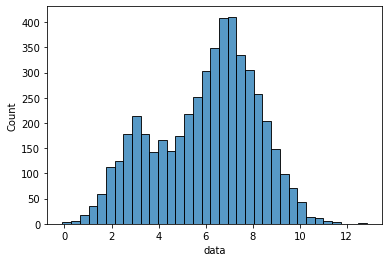

In [ ]:
# Set randomization seed
np.random.seed(3698)

# Generate data
data, classes = generate_ugmm(N, gt_means, gt_variances, gt_weights)

# Visualize distribution 
df = pd.DataFrame({'data': data, 'classes': classes})
sns.histplot(df, x='data') # add `hue='classes'` to see the classes distribution
plt.show()

### **Parameter estimation**

We then use the EM algorithm to fit the GMM to the generated dataset.

In [ ]:
# Set randomization seed
np.random.seed(3698)

# Set initial parameters
init_means = np.random.choice(data, 2, replace=False)
init_variances = [np.var(data) for _ in range(2)]
init_weights = [0.5 for _ in range(2)]

# Perform EM
result = em_ugmm(data, init_means, init_variances, init_weights)

### **Result visualization**

In [ ]:
print('Means:', result['means'])
print('Variances:', result['variances'])
print('Mixing weights:', result['weights'])

Means: [2.96809698 6.93930716]
Variances: [0.9327071  2.12255552]
Mixing weights: [0.23607766 0.76392234]


In other words, the prediction is
$$
    X \sim 0.24 N(2.96, 0.93) + 0.76 N(6.94, 2.12)
$$
which is pretty close to our ground truth generative model.

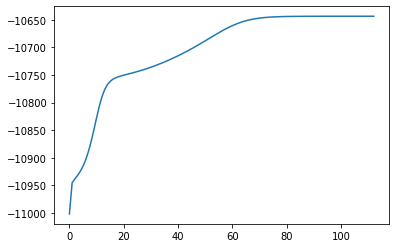

In [ ]:
sns.lineplot(data=result['loglikelihood'])
plt.show()

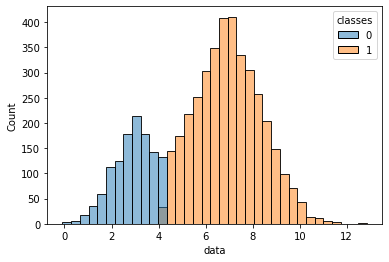

In [ ]:
df = pd.DataFrame({'data': data, 'classes': np.argmax(result['resp'], axis=1)})
sns.histplot(df, x='data', hue='classes')
plt.show()

# **4. Example 2 : Multivariate Gaussian Mixture Model**

## **4.1. Problem statements**

Everything is almost the same as the univariate case, except:

- The observable data is a collections of $D$-dimensional (column) vector instead of $1$-dimensional, i.e. $X = (\vec{x}_1, \vec{x}_2, \ldots, \vec{x}_n)^T$ with $\vec{x}_i \in \mathbb{R}^d$.
- The multivariate normal distribution is parameterized by the mean vector $\vec{\mu}$ and the covariance matrix $\Sigma$. The random vector $\vec{X}$ is said to follow the D-dimensional normal distribution, denoted by $\vec{X} \sim N_D(\vec{\mu}, \Sigma)$, when it has the pdf of
$$
    f(\vec{x}; \vec{\mu}, \Sigma)
    = \dfrac{1}{\sqrt{(2\pi)^k|\Sigma|}} \exp{-\dfrac{1}{2} (\vec{x} - \vec{\mu}) \Sigma^{-1} (\vec{x}-\vec{\mu})^T}
$$
- A D-dimensional Gaussian mixture is a model parameterized by $\theta = (M\mu, \Sigma, \vec{\pi})$ and has the pdf of
$$
    f(\vec{x}; \theta) = \sum_{k=1}^{K} \pi_k f_{N_D}(\vec{x}; \vec{\mu}_k, \Sigma_k)
$$
where:
    - $K$ is the number of components in the mixture, 
    - $M\mu = (\vec{\mu}_1, \vec{\mu}_2, \ldots, \vec{\mu}_K)$ and $\varsigma = (\Sigma_1, \Sigma_2, \ldots, \Sigma_K)$ are the parameters of each component in the mixture,
    - $\vec{\pi} = (\pi_1, \pi_2, \ldots, \pi_K)$ are the mixing weights.

In [ ]:
def generate_gmm(sample_size: int, 
                  means: List[List[float]], 
                  covariances: List[List[List[float]]], 
                  weights: List[float]) -> Union[np.array, np.array]:
    '''
        Generate data sampled from a Gaussian mixture.
    '''

    # Decide which distribution each point belongs to
    classes = np.random.choice(len(weights), sample_size, p=weights)

    # Generate a point as a random sample of its corresponding distribution
    data = np.array([
        np.random.multivariate_normal(means[k], covariances[k]) 
        for k in classes
    ])

    return data, classes

The log-likelihood is
$$
    l(\theta) 
    = \sum_{i=1}^{N} \log \sum_{k=1}^{K} \pi_k f_{N_D}(\vec{x}_i; \vec{\mu}_k, \Sigma_k)
$$

In [ ]:
def log_sum_exp(T: List[float]) -> float:
    '''
        Compute $\log{\sum_i \exp{T_i}}$ for a vector T.

        We use the fact that:
        \log \sum \exp T_i 
            = T_max + \log \sum \exp (T_i - T_max)
    '''
    return np.max(T) + np.log(np.sum(np.exp(T - np.max(T))))

def loglikelihood_gmm(data: List[float], 
                      means: List[float], 
                      covariances: List[float], 
                      weights: List[float]) -> float:
    '''
        Compute the log-likelihood of the data for a Univariate Gaussian 
        Mixture Model with the given parameters.
    '''
    K = len(weights)
    D = len(data[0])
    ll = 0

    # Iterate over all data
    for x in data:
        # Compute the exponentiation term for each class k
        T = np.zeros(K)
        for k in range(K):
            d = x - means[k]
            e = np.dot(d, np.dot(np.linalg.inv(covariances[k]), d))
            T[k] += np.log(weights[k])
            T[k] -= 1/2. * (D * np.log(2 * np.pi) + np.log(np.linalg.det(covariances[k])) + e)

        # Calculate the logarithm of the sum of the above exponentials
        ll += log_sum_exp(T)
    return ll

## **4.2. Parameter estimation using EM**

### **E-Step**

In E-step, we compute
$$
    g(\theta|\theta^{(t)})
    = \sum_{i=1}^{N} \sum_{k=1}^{K} \gamma_{i, k}^{(t)} [\log \pi_k + \log f_{N_D}(\vec{x}_i; \vec{\mu}_k, \Sigma_k)]
$$
where
$$
    \gamma_{i, k}^{(t)} = \dfrac{\pi^{(t)}_k f_{N_D}(\vec{x}_i; \vec{\mu}^{(t)}_k, \Sigma^{(t)}_k)}{\sum_{j=1}^{K} \pi^{(t)}_j f_{N_D}(\vec{x}_i; \vec{\mu}^{(t)}_j, \Sigma^{(t)}_j)}
$$

In [ ]:
def e_step_gmm(N, K, data, means_t, covariances_t, weights_t):
    resp_t = np.zeros((N, K))

     # Compute the responsibility matrix
    for i in range(N):
        for k in range(K):
            fN = multivariate_normal.pdf(data[i], means_t[k], covariances_t[k])
            resp_t[i, k] = weights_t[k] * fN
        
    # Normalize by row sum
    row_sums = resp_t.sum(axis=1)[:, np.newaxis]
    resp_t /= row_sums

    return resp_t

### **M-Step**

We find $\theta^{(t+1)}$ by finding the parameters maximizing $g(\theta| \theta^{(t)})$.

For the **means** and **covariances**,
$$
    \vec{\mu_k}^{(t+1)} = 
    \dfrac{1}{\sum_{i=1}^{N} \gamma^{(t)}_{i, k}}
    \sum_{i=1}^{N}\gamma^{(t)}_{i, k} \vec{x_i}
$$
and
$$
    \Sigma_k^{(t+1)} = \dfrac{1}{\sum_{i=1}^{N} \gamma^{(t)}_{i, k}} \sum_{i=1}^{N} \gamma^{(t)}_{i, k} (\vec{x_i} - \vec{\mu_k}^{(t+1)}) (\vec{x_i} - \vec{\mu_k}^{(t+1)})^T
$$

For the **weights**,
$$
    \pi_k^{(t+1)} = \dfrac{1}{N} \sum_{i=1}^{N} \gamma^{(t)}_{i, k}
$$

In [ ]:
def m_step_gmm(N, K, D, data, resp_t, means_t, covariances_t, weights_t):
    # Compute the total responsibility
    total_resp_t = np.sum(resp_t, axis=0)
    
    # Update the means
    means = np.matmul(resp_t.T, data)
    means /= total_resp_t[:, np.newaxis]

    # # Update the variances
    covariances = np.zeros((K, D, D))
    for k in range(K):
        for i in range(N):
            covariances[k] += resp_t[i, k] * np.outer(data[i] - means_t[k], data[i] - means_t[k])
    covariances /= total_resp_t[:, np.newaxis, np.newaxis]

    # Update the weights
    weights = total_resp_t / N

    return means, covariances, weights

### **Iteration**

In [ ]:
def em_gmm(data: List[float], 
            init_means: List[float], 
            init_covariances: List[float], 
            init_weights: List[float], 
            maxiter: int = 1000, 
            thresh: float = 1e-4) -> Dict[str, Union[List[float]]]:
    '''
        Perform the EM algorithm to estimate the parameters of a
        Gaussian Mixture Model based on the given data.
    '''
    # Parameters to update
    means_t = init_means
    covariances_t = init_covariances
    weights_t = init_weights
    
    # Sample size and number of clusters
    N = len(data)
    K = len(init_weights)
    D = len(data[0])
    
    # Log-likelihood history
    ll = loglikelihood_gmm(data, init_means, init_covariances, init_weights)
    ll_history = [ll]
    
    # Iterations of the EM algorithm
    for t in tqdm(range(maxiter)):
        # E-step
        resp_t = e_step_gmm(N, K, data, means_t, covariances_t, weights_t)

        # == M-step ==
        means_t, covariances_t, weights_t = m_step_gmm(N, K, D, data, resp_t, means_t, covariances_t, weights_t)

        # Compute the loglikelihood at this iteration
        ll_t = loglikelihood_gmm(data, means_t, covariances_t, weights_t)
        ll_history.append(ll_t)
        
        # Check for convergence in log-likelihood
        if (ll_t - ll) < thresh and ll_t > -np.inf:
            break
        ll = ll_t
    
    out = {'weights': weights_t, 'means': means_t, 'covariances': covariances_t, 
           'loglikelihood': ll_history, 
           'resp': resp_t}

    return out

## **4.3. Demonstration**

Generate toy dataset.

In [ ]:
N = 5000
K = 3
D = 2

gt_means = np.array([
    [4., 0.],
    [1., 1.],
    [2., 4]
])
gt_covariances = np.array([
    [[.5, .01],
     [.01, 1.5]],
    [[.9, .4],
     [.4, .8]],
    [[.5, .1],
     [.1, .1]]
])
gt_weights = np.array([0.2, 0.45, 0.35])

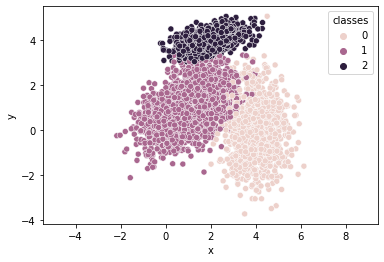

In [ ]:
# Set randomization seed
np.random.seed(3698)

# Generate data
data, classes = generate_gmm(N, gt_means, gt_covariances, gt_weights)

# Visualize distribution
df = pd.DataFrame({'x': data[:, 0], 
                   'y': data[:, 1], 
                   'classes': classes})
sns.scatterplot(data=df, x='x', y='y', hue='classes') # add `hue='classes'` to see the classes distribution
plt.axis('equal')
plt.show()

Parameter estimation using the EM algortihm.

In [ ]:
# Set randomization seed
np.random.seed(3698)

# Set initial parameters
init_means = np.array(data[np.random.choice(range(N), 3, replace=False)])
init_covariances = np.array([np.cov(data, rowvar=0) for _ in range(3)])
init_weights = np.array([1/3. for _ in range(3)])

# Perform EM
result = em_gmm(data, init_means, init_covariances, init_weights)

Visualization of the result.

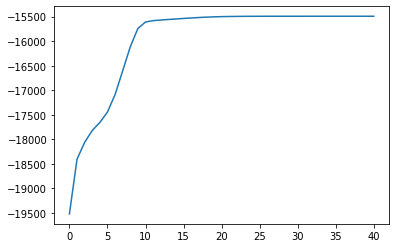

In [ ]:
sns.lineplot(data=result['loglikelihood'])
plt.show()

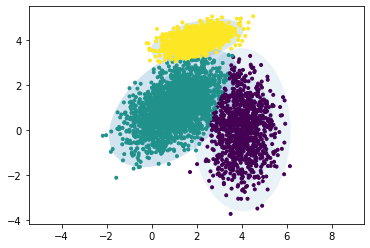

In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, 
                             nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(data, classes, means, covariances, weights):
    ax = plt.gca()
    ax.scatter(data[:, 0], data[:, 1], c=classes, zorder=2, cmap='viridis', marker='.')
    ax.axis('equal')
    
    w_factor = 0.2 / weights.max()
    for pos, covar, w in zip(means, covariances, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.show()

plot_gmm(data, np.argmax(result['resp'], axis=1), result['means'], result['covariances'], result['weights'])

Evolution of prediction through each iteration.

Initial parameters


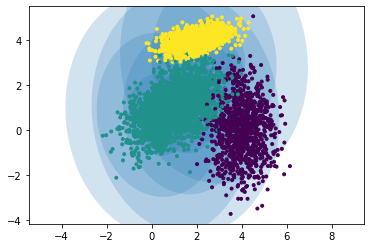

Iteration 1


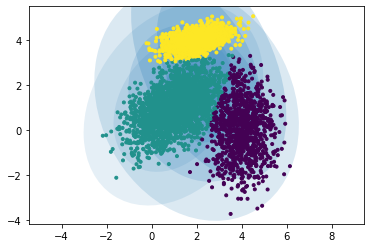

Iteration 2


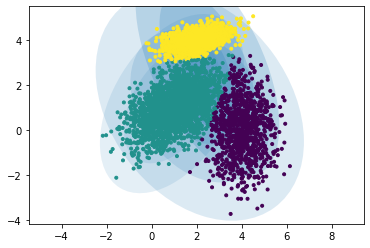

Iteration 3


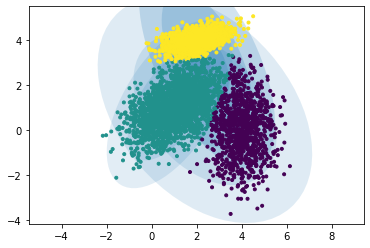

Iteration 4


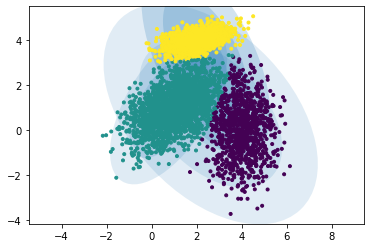

Iteration 5


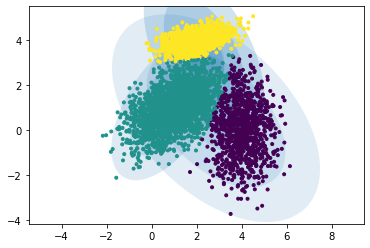

Iteration 6


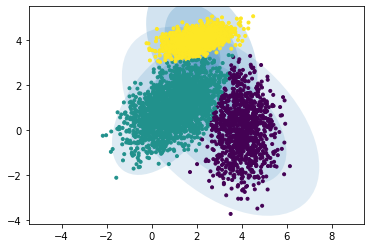

Iteration 7


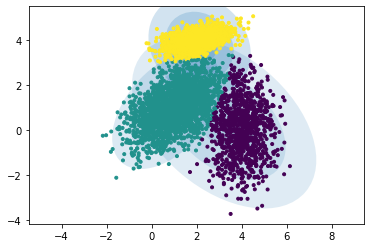

Iteration 8


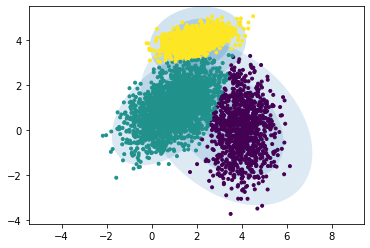

Iteration 9


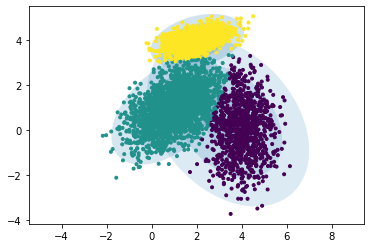

Iteration 10


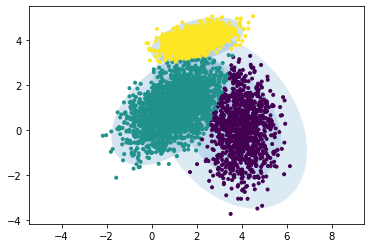

Iteration 11


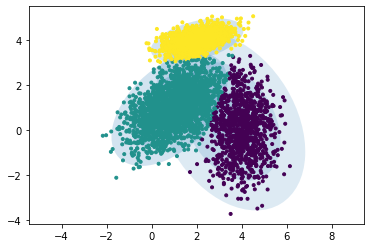

Iteration 12


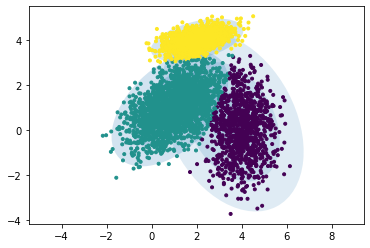

Iteration 13


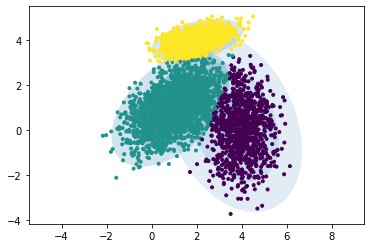

Iteration 14


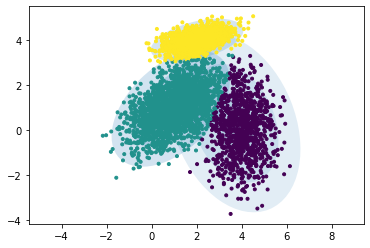

Iteration 15


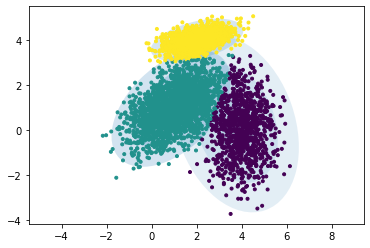

Iteration 16


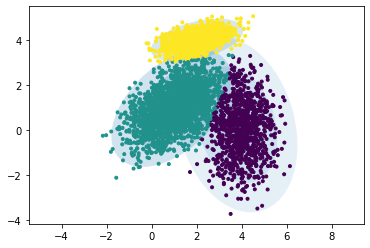

Iteration 17


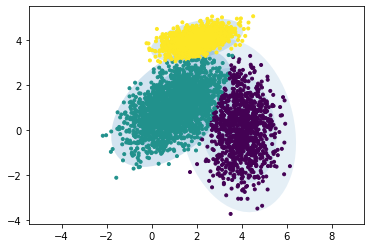

Iteration 18


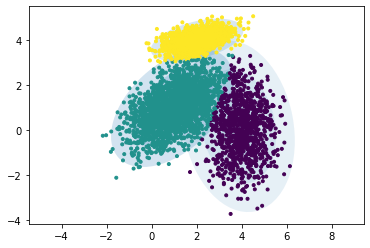

Iteration 19


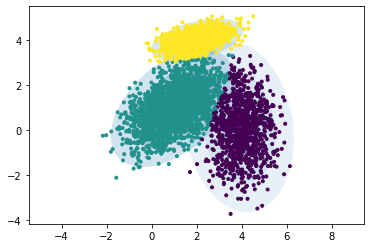

Iteration 20


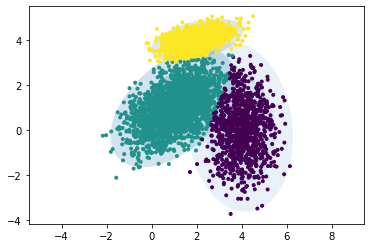

In [ ]:
print('Initial parameters')
means, covariances, weights = init_means, init_covariances, init_weights
plot_gmm(data, classes, means, covariances, weights)

for i in range(20):
    print('Iteration', i + 1)
    temp_result = em_gmm(data, means, covariances, weights, maxiter=1)
    means, covariances, weights = temp_result['means'], temp_result['covariances'], temp_result['weights']
    predictions = np.argmax(result['resp'], axis=1)
    plot_gmm(data, predictions, means, covariances, weights)

Comparison with K-Means Clustering

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=3698)
labels = kmeans.fit_predict(data)

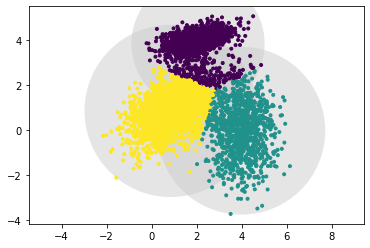

In [ ]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', zorder=2, marker='.')
    ax.axis('equal')

    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(kmeans, data)

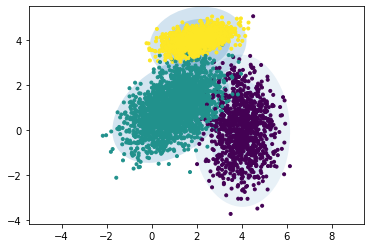

In [ ]:
# Set initial parameters
init_means = kmeans.cluster_centers_
init_covariances = np.array([np.cov(data[labels == k], rowvar=0) for k in range(K)])
init_weights = np.array([(labels == k).sum() / N for k in range(K)])

# Visualize initialization
plot_gmm(data, classes, init_means, init_covariances, init_weights)

# Perform EM
result_kmeans = em_gmm(data, init_means, init_covariances, init_weights)

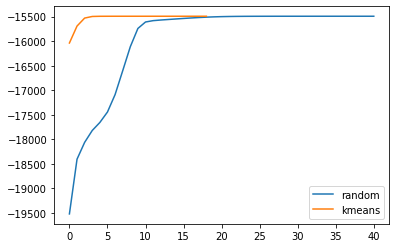

In [ ]:
sns.lineplot(data=result['loglikelihood'], label='random')
sns.lineplot(data=result_kmeans['loglikelihood'], label='kmeans')
plt.legend()
plt.show()

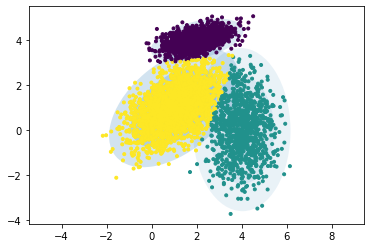

In [ ]:
plot_gmm(data, np.argmax(result_kmeans['resp'], axis=1), result_kmeans['means'], result_kmeans['covariances'], result_kmeans['weights'])

# **5. Example 3: Clustering of MNIST**

In [ ]:
# !wget https://pjreddie.com/media/files/mnist_train.csv
!wget https://pjreddie.com/media/files/mnist_test.csv

--2021-05-31 11:16:36--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  19.8MB/s    in 0.9s    

2021-05-31 11:16:37 (19.8 MB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [ ]:
data = pd.read_csv('mnist_test.csv', header=None).to_numpy()
X = data[:, 1:] / 255.
y = data[:, 0]

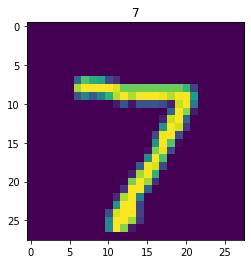

In [ ]:
def plot_mnist(x, y, ax=None):
    ax = ax or plt.gca()
    ax.imshow(x.reshape((28, 28)))
    ax.set_title(y)

plot_mnist(X[0], y[0])

In [ ]:
N = len(X)
D = len(X[0])
K = 10

# Set randomization seed
np.random.seed(3698)

# Set initial parameters
init_means = np.array(X[np.random.choice(range(N), K, replace=False)])
init_covariances = np.array([np.cov(X, rowvar=0) for _ in range(K)])
init_weights = np.array([1/3. for _ in range(K)])

# Perform EM
try:
    result = em_gmm(X, init_means, init_covariances, init_weights)
except Exception as e:
    print('[ERROR]', e)

[ERROR] Singular matrix


In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(10, random_state=3698)
labels = gmm.fit_predict(X)

Cluster 0


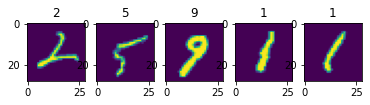

Cluster 1


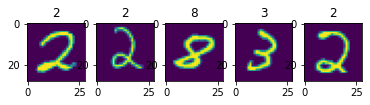

Cluster 2


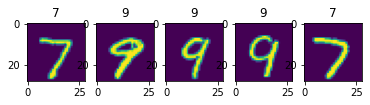

Cluster 3


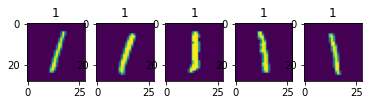

Cluster 4


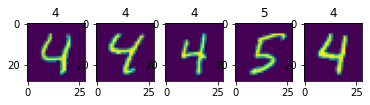

Cluster 5


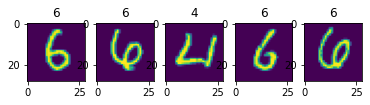

Cluster 6


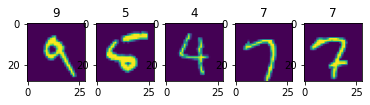

Cluster 7


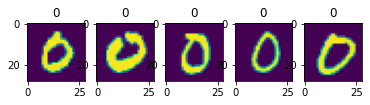

Cluster 8


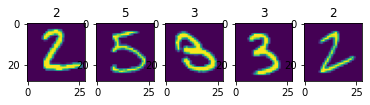

Cluster 9


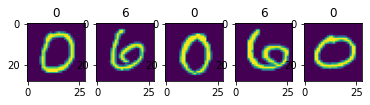

In [ ]:
for k in range(K):
    print('Cluster', k)

    fig, axes = plt.subplots(1, 5)
    for i, (x, yy) in enumerate(zip(X[labels == k][:5], y[labels == k][:5])):
        plot_mnist(x, yy, axes[i])
    plt.show()

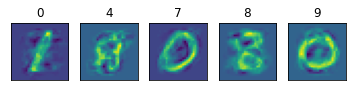

In [ ]:
fig, axes = plt.subplots(1, 5)
for i, (x, y) in enumerate(zip(*gmm.sample(5))):
    plot_mnist(x, y, axes[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])